# benchmark.ipynb

This notebook contains the text and code for the next blog post in the zero-copy model series, 
title TBD.

The first post explained how to load PyTorch models for inference extremely fast by leveraging the Plasma object store's ability to load numeric data directly from shared memory.

In this post, we talk in more concrete terms about how to use this zero-copy model loading for model serving. We put together a simple model serving system, then set up a microbenchmark that simulates a heavy-tailed traffic pattern.

In [1]:
# Initialization and import code goes in this cell.

# Imports: Python core, then third-party, then local.
# Try to keep each block in alphabetical order, or the linter may get angry.

import asyncio
import concurrent.futures
import requests
import starlette
import time
import os
import json

from typing import Dict, Callable, Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ray
from ray import serve
import torch
import transformers

import zerocopy

# Fix silly warning messages about parallel tokenizers
os.environ['TOKENIZERS_PARALLELISM'] = 'False'


# Reduce the volume of warning messages from `transformers`
transformers.logging.set_verbosity_error()


def reboot_ray():
    if ray.is_initialized():
        ray.shutdown()

    if torch.cuda.is_available():
        return ray.init(num_gpus=1)
    else:
        return ray.init()

# Title of new blog post goes here

*Recap of previous blog post goes here.*

In a [previous post](https://medium.com/ibm-data-ai/how-to-load-pytorch-models-340-times-faster-with-ray-8be751a6944c), we introduced the concept of *zero-copy model loading*. Zero-copy model loading involves keeping the weights of a deep learning model in shared memory, so that different processes can "load" the model for inference without 

showed that 
The Plasma object store integrated into Ray makes it easy to do zero-copy model loading

and that implementing this technique on Ray can accelerate model loading by several orders of magnitude.

If you'd like to find out more about these

follow [this link](https://medium.com/ibm-data-ai/how-to-load-pytorch-models-340-times-faster-with-ray-8be751a6944c) to view the previous post.


Today's post goes into the details of how to use zero-copy model loading for production deployments of large natural language processing (NLP) models. We introduce `zerocopy`, a Python package that makes it extra simple to apply zero-copy model loading to PyTorch models. We show how easy it is to deploy modern NLP models using with `zerocopy` and Ray Serve. Finally, we present an end-to-end model serving benchmark that shows how we can serve 12 state-of-the-art NLP models with a single cloud VM and achieve (**TODO: final numbers**)x better scalability.
  
But before we get into these details, we need to give some background about the end-to-end scenario we'll be targeting with our benchmark and the NLP models that use to cover this scenario.

## The Scenario

The end-to-end scenario for our benchmark involves supporting an AI chatbot.
The chatbot's conversational AI runs off of a conversation tree. Some of the 
nodes of this tree invoke models.


> **TODO:** Cartoon block diagram of the end-to-end scenario. 
> Diagram should show a user interacting with a chatbot. The chatbot runs off of a conversation tree. 
> Some of the nodes of the conversation tree have question answering models hanging off of them.



Our benchmark will cover the model serving portion of the chatbot's backend. This 
model serving layer runs four different types of models:
* *Intent detection* models that determine what is the user's goal.
* *Sentiment analysis* models that monitor the user's mood.
* *Question answering* models that provide the answers to specific factual questions.
* *Natural language generation* models that give the chatbot's responses a less scripted flavor.

Because the chatbot speaks 3 different languages, there are three versions of
each model deployed: one for each language. So the model serving layer runs a total of
12 models.

In a real application, you would want to train custom versions of each type
of model for the topics your chatbot covers.
Since we're only interested in modeling throughput and latency, we skipped that customization
step and just used the most popular pretrained model from each category from the 
[Huggingface model marketplace](https://huggingface.co/models).

Each of these models uses a [Transformer](https://arxiv.org/abs/1706.03762)-based neural network,
with a *language model* and a task specific *head*, tuned over 
a domain-specific training set.  The table below summarizes the four models that we used.


| Task                 | Model Name                                   | Language Model  |  Pre/post Processing
| -----------          | -----------                                  | ------------    | ---------------
| Intent Detection     | `mrm8488/t5-base-finetuned-e2m-intent`       | T5              | Reference code
| Sentiment Analysis   | `cardiffnlp/twitter-roberta-base-sentiment`  | RoBERTa         | Reference code
| Question Answering   | `deepset/roberta-base-squad2`                | RoBERTa         | Pipeline
| Text Generation      | `gpt2`                                       | GPT-2           | Pipeline


Although all four models came from the same marketplace, they are quite diverse. The models use three different core language models: [Text-to-Text Transfer Transformer](https://arxiv.org/pdf/1910.10683.pdf) (T5) from Google Research, 
[RoBERTa](https://arxiv.org/pdf/1907.11692.pdf) from Facebook AI, and [GPT-2](https://d4mucfpksywv.cloudfront.net/better-language-models/language-models.pdf) from OpenAI. 

NLP models generally require *preprocessing* to convert natural language text into a format amenable to 
model inference and *postprocessing* to convert the answer into a format that a person can understand. All four of our models come with code for these crucial steps, but models use two very different ways to package this code. The intent and sentiment models provide small blocks of reference Python code, with the intent being that the user will adapt this reference code to the specific circumstances of the end-to-end appliction.

For example, the code block below loads and runs the intent model using code adapted from the provided example code:

In [2]:
INTENT_MODEL_NAME = 'mrm8488/t5-base-finetuned-e2m-intent'

# Load model and tokenizer
intent_tokenizer = transformers.AutoTokenizer.from_pretrained('t5-base')
intent_model = transformers.AutoModelForSeq2SeqLM.from_pretrained(
    INTENT_MODEL_NAME)

# Example input
INTENT_INPUT = {
    'context':
        ("I came here to eat chips and beat you up, "
         "and I'm all out of chips.")
}

# Preprocessing
input_text = f'{INTENT_INPUT["context"]} </s>'
features = intent_tokenizer([input_text], return_tensors='pt')

# Inference
output = intent_model.generate(**features)

# Postprocessing
result_string = intent_tokenizer.decode(output[0])
result_string = result_string.replace('<pad>', '')
result_string = result_string[len(' '):-len('</s>')]

result_string

'to eat'

The question answering and text generation models both use the Huggingface `tokenizers` library's [Pipelines API](https://huggingface.co/docs/transformers/main_classes/pipelines) to package their preprocessing and postprocesing code.
The following code snippet demonstrates the process of loading and running the question answering model using this API.

In [3]:
QA_MODEL_NAME = 'deepset/roberta-base-squad2'

# Loading the model and associated resources
qa_pipeline = transformers.pipeline('question-answering',
                                    model=QA_MODEL_NAME)

# Example input
# TODO: For the blog post, truncate the context string.
QA_INPUT = {
    'question': 'What is 1 + 1?',
    'context': 
        """Addition (usually signified by the plus symbol +) is one of the four basic operations of 
        arithmetic, the other three being subtraction, multiplication and division. The addition of two 
        whole numbers results in the total amount or sum of those values combined. The example in the
        adjacent image shows a combination of three apples and two apples, making a total of five apples. 
        This observation is equivalent to the mathematical expression "3 + 2 = 5" (that is, "3 plus 2 
        is equal to 5").
        """
}

# Preprocessing, inference, and postprocessing all happen in
# the Python object's the __call__() method.
qa_result = qa_pipeline(**QA_INPUT)

qa_result

{'score': 4.278938831703272e-06, 'start': 483, 'end': 484, 'answer': '5'}

Unlike the "example reference code" approach, the Pipelines API's end-to-end inference code is intended for direct production use. It includes support for model retraining, as well as performance optimizations like batching and GPU acceleration, plus code for handling corner cases like long input strings. This prepackaged code can save a lot of time, provided that your application is structured in a way that can easily accomodate a large block of non-modifiable third-party Python code.


## Introducing `zerocopy`

We've created a Python package, `zerocopy`, with the model rewrite code from our previous post (TODO: Publish the package to PyPI).

To use that package, you'll need to install it with `pip`, then import it into your script.

```python
import zerocopy
```


(TODO: Insert description of how `zero_copy` strips off the weights of a model
and provides a way to reconsitute them from Plasma)



The low-level process works for all of our example models. Here it is in action with the intent model.

In [4]:
# Don't include this cell in the blog post.
serve.shutdown()
reboot_ray()
serve.start()

# Wait a moment to make sure that all log output goes to this cell
time.sleep(1.)

2022-03-02 11:14:33,034	INFO services.py:1374 -- View the Ray dashboard at http://127.0.0.1:8265
(ServeController pid=6014) 2022-03-02 11:14:37,418	INFO checkpoint_path.py:16 -- Using RayInternalKVStore for controller checkpoint and recovery.
(ServeController pid=6014) 2022-03-02 11:14:37,527	INFO http_state.py:98 -- Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:PqJsBM:SERVE_PROXY_ACTOR-node:127.0.0.1-0' on node 'node:127.0.0.1-0' listening on '127.0.0.1:8000'
2022-03-02 11:14:37,966	INFO api.py:475 -- Started Serve instance in namespace '920c26c7-98b1-420a-91f5-c65831bfef20'.
(HTTPProxyActor pid=6015) INFO:     Started server process [6015]


In [5]:
# Recall that we loaded `intent_model` in an earlier cell.

# Preprocessing
input_text = f'{INTENT_INPUT["context"]} </s>'
features = intent_tokenizer([input_text], return_tensors='pt')

# Inference without zero-copy loading
print('Result without zero-copy loading: '
      + str(intent_model.generate(**features)))

# Inference with zero-copy loading
intent_model_ref = ray.put(zerocopy.extract_tensors(intent_model))
print(' Result *with* zero-copy loading: ' +
      str(ray.get(zerocopy.call_model.remote(
          intent_model_ref, [], features, 'generate'))))

Result without zero-copy loading: tensor([[   0,   12,    3, 1544,    1]])
 Result *with* zero-copy loading: tensor([[   0,   12,    3, 1544,    1]])


The time to invoke the rewritten model once is almost the same as running the model locally.

In [6]:
print("       Time to run locally: ", end="")
%timeit intent_model.generate(**features)
print("Time to run with zero-copy: ", end="")
%timeit ray.get(zerocopy.call_model.remote(intent_model_ref, [], features, 'generate'))

       Time to run locally: 275 ms ± 5.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Time to run with zero-copy: 280 ms ± 3.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


If we run inference multiple times, `zero_copy.call_model()` can send those inference requests to separate Ray tasks that run in parallel.

In [7]:
def run_local(num_repeats: int):
    for _ in range(num_repeats):
        intent_model.generate(**features)


def run_zero_copy(num_repeats: int):
    futures = [
        zerocopy.call_model.remote(intent_model_ref, [], features, 'generate')
        for _ in range(num_repeats)]
    ray.get(futures)


NUM_REPEATS = 50
print(f"Time to run {NUM_REPEATS} times with zero-copy: ", end="")
%timeit -r 3 run_zero_copy(NUM_REPEATS)
print(f"       Time to run {NUM_REPEATS} times locally: ", end="")
%timeit -r 3 run_local(NUM_REPEATS)

Time to run 50 times with zero-copy: 6.28 s ± 99.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
       Time to run 50 times locally: 13.9 s ± 215 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


The question answering and text generation models in our benchmark come packaged as `transformers` model pipelines. For convenience, the `zerocopy` library includes a function `rewrite_pipeline` that transforms any models embedded into Python object into Ray tasks that use zero-copy model loading to load weights. If we apply this function to a pipeline, the resulting rewritten pipeline faithfully performs all the preprocessing and postprocessing that the original pipeline performed. However, this rewritten pipeline runs the embedded PyTorch model in remote Ray tasks.

In [8]:
zero_copy_qa = zerocopy.rewrite_pipeline(qa_pipeline)
print(f"Before rewrite: {qa_pipeline(**QA_INPUT)}")
print(f" After rewrite: {zero_copy_qa(**QA_INPUT)}")

Before rewrite: {'score': 4.278938831703272e-06, 'start': 483, 'end': 484, 'answer': '5'}
 After rewrite: {'score': 4.278938831703272e-06, 'start': 483, 'end': 484, 'answer': '5'}


## Deploying Models with `zerocopy` and Ray Serve

In [9]:
serve.shutdown()
reboot_ray()
serve.start()

2022-03-02 11:16:51,788	INFO services.py:1374 -- View the Ray dashboard at http://127.0.0.1:8265
(ServeController pid=6116) 2022-03-02 11:16:55,988	INFO checkpoint_path.py:16 -- Using RayInternalKVStore for controller checkpoint and recovery.
(ServeController pid=6116) 2022-03-02 11:16:56,099	INFO http_state.py:98 -- Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:KRWRcF:SERVE_PROXY_ACTOR-node:127.0.0.1-0' on node 'node:127.0.0.1-0' listening on '127.0.0.1:8000'
2022-03-02 11:16:56,513	INFO api.py:475 -- Started Serve instance in namespace '49755261-3f6f-4b7b-80b7-96cf71f63cd3'.


Text goes here

In [10]:
@serve.deployment
class Intent:
    def __init__(self):
        self._tokenizer = transformers.AutoTokenizer.from_pretrained('t5-base')
        model = transformers.AutoModelForSeq2SeqLM.from_pretrained(
                    INTENT_MODEL_NAME)
        
        # Extract weights and load them onto the Plasma object store
        self._model_ref = ray.put(zerocopy.extract_tensors(model))

    async def __call__(self, request: starlette.requests.Request):
        json_request = await request.json()
        
        # Preprocessing
        input_text = f'{json_request["context"]} </s>'
        features = self._tokenizer([input_text], return_tensors='pt')

        # Model inference runs asynchronously in a Ray task
        output = await zerocopy.call_model.remote(
            self._model_ref, [], features, 'generate')

        # Postprocessing
        result_string = self._tokenizer.decode(output[0])
        result_string = result_string[len('<pad> '):-len('</s>')]
        return {
            'intent': result_string
        }

Text goes here

In [11]:
@serve.deployment
class QA:
    def __init__(self):
        # Load the pipeline and move the model's weights onto the
        # Plasma object store.
        self._pipeline = zerocopy.rewrite_pipeline(
            transformers.pipeline('question-answering', 
                                  model=QA_MODEL_NAME))
        self._threadpool = concurrent.futures.ThreadPoolExecutor()

    async def __call__(self, request: starlette.requests.Request):
        json_request = await request.json()

        # The original `transformers` code is not async-aware, so we
        # call it from `run_in_executor()`
        result = await asyncio.get_running_loop().run_in_executor(
             self._threadpool, lambda: self._pipeline(**json_request))
        return result

Text goes here

In [12]:
Intent.options(name='intent_en', ray_actor_options={"num_cpus": 0.1}).deploy()
QA.options(name='qa_en', ray_actor_options={"num_cpus": 0.1}).deploy()

2022-03-02 11:16:56,549	INFO api.py:249 -- Updating deployment 'intent_en'. component=serve deployment=intent_en
(HTTPProxyActor pid=6118) INFO:     Started server process [6118]
(ServeController pid=6116) 2022-03-02 11:16:56,638	INFO deployment_state.py:920 -- Adding 1 replicas to deployment 'intent_en'. component=serve deployment=intent_en
(intent_en pid=6119) The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
2022-03-02 11:17:07,138	INFO api.py:261 -- Deployment 'intent_en' is ready at `http://127.0.0.1:8000/intent_en`. component=serve deployment=intent_en
2022-03-02 11:17:07,149	INFO api.py:249 -- Updating deployment 'qa_en'. component=serve deployment=qa_en
(ServeController pid=6116) 2022-03-02 11:17:07,241	INFO deployment_state.py:920 -- Adding 1 replicas to deployment 'qa_en'. component=serve deployment=qa_en
2022-03-02 11:17:16,808	INFO api.py:261 -- Deployment 'qa_en' is ready at `ht

Text goes here

In [13]:
intent_result = requests.put(
    'http://127.0.0.1:8000/intent_en',
    json.dumps(INTENT_INPUT)).json()
print(f'Intent result: {intent_result}')

qa_result = requests.put(
    'http://127.0.0.1:8000/qa_en',
    json.dumps(QA_INPUT)).json()
print(f'Question answering result: {qa_result}')

Intent result: {'intent': 'to eat'}
Question answering result: {'score': 4.278938831703272e-06, 'start': 483, 'end': 484, 'answer': '5'}


In [14]:
# Don't include this cell in the blog.
# Stop this notebook's copy of Ray so as not to interfere with the
# copy in `ray_deploy.ipynb`
serve.shutdown()
ray.shutdown()

(ServeController pid=6116) 2022-03-02 11:17:35,924	INFO deployment_state.py:940 -- Removing 1 replicas from deployment 'intent_en'. component=serve deployment=intent_en
(ServeController pid=6116) 2022-03-02 11:17:35,928	INFO deployment_state.py:940 -- Removing 1 replicas from deployment 'qa_en'. component=serve deployment=qa_en


## Baseline implementation

Our baseline implementation of the model serving backend for our benchmark emulates running each model in a separate container. We used [TorchServe](https://pytorch.org/serve/) as our model serving framework for the baseline deployment. By configuing TorchServe to use a pool of processes, we were able to simulate running each model in a separate container without having to set up a dedicated Kubernetes cluster. See [this notebook](./torchserve.ipynb) for details of the TorchServe deployment.

*Note that earlier versions of this notebook implemented the baseline model deployment with a pool of Ray actors. That older version is preserved in [a separate notebook](./ray_baseline.ipynb).*

With TorchServe running in the background, we can invoke our models via their REST APIs.

In [15]:
# Don't include this cell in the blog.
# Probe the management API to verify that TorchServe is running.
try:
    print(requests.get('http://127.0.0.1:8081/models').json())
except requests.exceptions.ConnectionError:
    # Stop notebook execution
    raise ValueError('TorchServe does not appear to be running. Please start TorchServe.') from None

{'models': [{'modelName': 'generate_en', 'modelUrl': 'generate.mar'}, {'modelName': 'generate_es', 'modelUrl': 'generate.mar'}, {'modelName': 'generate_zh', 'modelUrl': 'generate.mar'}, {'modelName': 'intent_en', 'modelUrl': 'intent.mar'}, {'modelName': 'intent_es', 'modelUrl': 'intent.mar'}, {'modelName': 'intent_zh', 'modelUrl': 'intent.mar'}, {'modelName': 'qa_en', 'modelUrl': 'qa.mar'}, {'modelName': 'qa_es', 'modelUrl': 'qa.mar'}, {'modelName': 'qa_zh', 'modelUrl': 'qa.mar'}, {'modelName': 'sentiment_en', 'modelUrl': 'sentiment.mar'}, {'modelName': 'sentiment_es', 'modelUrl': 'sentiment.mar'}, {'modelName': 'sentiment_zh', 'modelUrl': 'sentiment.mar'}]}


In [17]:
TORCHSERVE_PORT = 8080
SENTIMENT_INPUT = {
    'context': "We're not happy unless you're not happy."
}
GENERATE_INPUT = {
    'prompt_text': 'All your base are'
}

intent_result = requests.put(
    f'http://127.0.0.1:{TORCHSERVE_PORT}/predictions/intent_en',
    json.dumps(INTENT_INPUT)).json()
print(f'Intent result: {intent_result}')

sentiment_result = requests.put(
    f'http://127.0.0.1:{TORCHSERVE_PORT}/predictions/sentiment_en',
    json.dumps(SENTIMENT_INPUT)).json()
print(f'Sentiment result: {sentiment_result}')

qa_result = requests.put(
    f'http://127.0.0.1:{TORCHSERVE_PORT}/predictions/qa_en',
    json.dumps(QA_INPUT)).json()
print(f'Question answering result: {qa_result}')

generate_result = requests.put(
    f'http://127.0.0.1:{TORCHSERVE_PORT}/predictions/generate_en',
    json.dumps(GENERATE_INPUT)).json()
print(f'Natural language generation result: {generate_result}')

Intent result: {'intent': 'to eat chips'}
Sentiment result: {'positive': 0.5419477820396423, 'neutral': 0.38251084089279175, 'negative': 0.07554134726524353}
Question answering result: {'score': 4.278938831703272e-06, 'start': 483, 'end': 484, 'answer': '5'}
Natural language generation result: [{'generated_text': "All your base are ready for those.\n\n2. Once you've added the base of each element, click on the first one to display the current layout.\n\n3. After clicking Add Add, there will now be an option to display"}]


## The Benchmark

Now that we have deployed each of our models with a web service front end, we can define a benchmark that sends inference traffic to these web service endpoints and measures response time.

We start by wrapping all the web services in a single callback function that calls a model, retrieves the result, verifies the result, and returns elapsed time.

In [18]:
# For now, we have a single canned input for each model type.
MODEL_INPUTS = {
    'intent': INTENT_INPUT,
    'sentiment': SENTIMENT_INPUT,
    'qa': QA_INPUT,
    'generate': GENERATE_INPUT
}

LANGUAGES = ['en', 'es', 'zh']


MODEL_TYPES = list(MODEL_INPUTS.keys())


def call_model(model_type: str, language: str, port: int,
               timeout_sec: float = 20.0) \
        -> Tuple[int, float, float]:
    '''
    Callack function that calls the model deployment, retrieves and
    validates the result, and returns elapsed time.

    :param model_type: Type of model to call; must be one of
                       'intent', 'sentiment', 'qa', or 'generate'
    :param language: Two-letter language code; must be one of
                     'en', 'es', 'zh'
    :param port: Port on which the local REST API is listening.
    :param timeout_sec: Request timeout, in seconds.

    :returns: Tuple of HTTP result code and start and end times 
              of the web service call. If a client-side timeout
              happens, the result code will be 408 (request timeout)
    '''
    if model_type not in MODEL_TYPES:
        raise ValueError(f'Unexpected model type "{model_type}" '
                         f'(expected {MODEL_TYPES}')
    if language not in LANGUAGES:
        raise ValueError(f'Unexpected language code "{language}" '
                         f'(expected {LANGUAGES}')

    # For now, use the same input every time
    model_input = MODEL_INPUTS[model_type]

    start_time = time.time()
    try:
        result = requests.put(
            f'http://127.0.0.1:{port}/predictions/{model_type}_{language}',
            json.dumps(model_input),
            timeout=timeout_sec)
        end_time = time.time()
        status_code = result.status_code
    except requests.exceptions.Timeout:
        end_time = start_time + timeout_sec
        status_code = 408  # HTTP/408 Request Timeout

    return (status_code, start_time, end_time)


In [19]:
TORCHSERVE_PORT = 8080

# Test with each model type
for model_type in MODEL_INPUTS.keys():
    times = call_model(model_type, 'en', TORCHSERVE_PORT)
    print(f'The "{model_type}" model takes {times[2] - times[1]:1.3f} seconds.')

The "intent" model takes 0.328 seconds.
The "sentiment" model takes 0.088 seconds.
The "qa" model takes 0.537 seconds.
The "generate" model takes 1.840 seconds.


Our benchmark generates a trace of requests, then plays back the trace and measures the 
latency of each request. 

The request rate changes each second, with the rate of a particular 1-second window drawn from the Poisson
distribution. Here's the code to generate the start times for the trace.

In [20]:
def gen_start_times(requests_per_sec: float, num_sec: int,
                    seed: int) -> np.ndarray:
    '''
    Generate a trace of inference request start times. Divides the trace
    into 1-second intervals. Each interval gets a number of requests drawn
    from a Poissson distribution. These requests are evenly spread through the
    interval.

    :param requests_per_sec: Average requests per second overall
    :param num_sec: Number of seconds of trace to generate
    :param seed: Seed for the random number generator

    :returns: Numpy array of timestamps (starting from 0) for the requests
     in the trace
    '''
    trace = []
    rng = np.random.default_rng(seed)

    # Compute the number of requests in each 1-second window.
    req_per_window = rng.poisson(requests_per_sec, size=num_sec)

    for window_num in range(num_sec):
        num_requests = req_per_window[window_num]
        if num_requests > 0:
            request_interval = 1.0 / num_requests
            for i in range(num_requests):
                trace.append(window_num + request_interval * i)

    return np.array(trace)

Each request goes to a randomly-selected model. The choice of models is
weighted according to a truncated Poisson distribution. Here's the code to generate
the list of model IDs for the requests in the trace. When we play back the trace,
we'll map each integer model ID to a combination of a language code and a model type
--- for example, `('en', 'sentiment')` for the English sentiment model.

In [21]:
def gen_model_ids(lambda_: float, num_models: int, num_points: int,
                  seed: int) -> np.ndarray:
    '''
    Draw integer model IDs at random from a truncated Poisson distribution.

    :param lambda_: Primary parameter of the distribution, which also happens to 
     be the mean value of the (untruncated) distribution.
    :param num_models: Number of models; generated IDs will range from 0 to
                       `num_models - 1`, inclusive.
    :param num_points: Number of random model IDs to return.
    :param seed: Seed for the random number generator

    :returns: Randomly generated model IDs for a series of requests, as a
     1D Numpy array of integers.
    '''
    rng = np.random.default_rng(seed)
    # Draw integers from a truncated Poisson distribution. Start with a 
    # non-truncated distribution, then resample for
    # any values that went over the limit.
    int_ids = rng.poisson(lambda_, size=num_points)
    while np.any(int_ids >= num_models):
        new_values = rng.poisson(lambda_, size=np.sum(int_ids >= num_models))
        int_ids[int_ids >= num_models] = new_values
    return int_ids


# Map the integer model IDs from the trace to pairs of language code and
# model type.
MODEL_ID_TO_PARAMS = [
    (lang_code, model_name)
    for lang_code in LANGUAGES
    for model_name in MODEL_TYPES
]


MODEL_ID_TO_PARAMS

[('en', 'intent'),
 ('en', 'sentiment'),
 ('en', 'qa'),
 ('en', 'generate'),
 ('es', 'intent'),
 ('es', 'sentiment'),
 ('es', 'qa'),
 ('es', 'generate'),
 ('zh', 'intent'),
 ('zh', 'sentiment'),
 ('zh', 'qa'),
 ('zh', 'generate')]

The benchmark itself generates and then plays back the trace, measuring the end-to-end latency of each request.

In [22]:
def run_single_benchmark(
        model_callback: Callable, 
        requests_per_sec: float,
        num_sec: int,
        model_id_to_params: List[Tuple[str, str]],
        model_lambda: float = 0.3,
        seed: int = 42) -> pd.DataFrame:
    '''
    A single run of the benchmark.

    Sends a stream of requests to multiple models, with the rate varying
    according to a Poisson distribution and division of traffic among models
    following a truncated Poisson distribution.

    :param model_callback: Thread-safe callback function that makes a 
                           single request and returns a tuple of
                           ``(result code, start time, end time)``.
                           Should have the signature
                           `f(model_type: str, language: str)`
    :param request_per_sec: Mean of the Poisson distribution that determines
     the number of requests in each 1-second window.
    :param num_sec: Seconds of traffic to generate at the requested rate.
     The actual session will extend past this window until all open requests
     have finished.
    :param model_lambda: Primary parameter of the truncated Poisson
     distribution used to split requests among models. Approximately
     equal to the mean of the distribution. The default value of 0.3 sends
     70% of traffic to model 0.
    :param model_id_to_params: List that maps integer model ID to a tuple of 
     (language code, model name) for each of the models.
    :param seed: Seed for the random number generator

    :returns: DataFrame of benchmark results at per-request granularity
    '''
    # Preallocate the trace as a set of lists.
    benchmark_start_time = time.time()
    desired_start_times = (
        gen_start_times(requests_per_sec, num_sec, seed)
        + benchmark_start_time)
    num_requests = desired_start_times.shape[0]
    model_nums = gen_model_ids(model_lambda, len(model_id_to_params),
                               num_requests, seed)
    language_codes = [model_id_to_params[num][0] for num in model_nums]
    model_types = [model_id_to_params[num][1] for num in model_nums]
    actual_start_times = [None] * num_requests
    end_times = [None] * num_requests
    result_codes = [None] * num_requests

    # Because some notebook servers (i.e. VSCode) don't play well with
    # asyncio, we use threads to manage concurrent requests.
    thread_pool = concurrent.futures.ThreadPoolExecutor(1000)

    # Map from request object to request number
    active_requests = {}  # type: Dict[concurrent.futures.Future, int]

    # Main event loop: Spawn background requests, get their responses.
    request_num = 0
    while request_num < num_requests or len(active_requests) > 0:
        sec_to_next = (
            1.0 if request_num >= num_requests
            else desired_start_times[request_num] - time.time()
        )
        if sec_to_next <= 0:
            # Time to send the next request
            lang_code = language_codes[request_num]
            model_type = model_types[request_num]
            future = thread_pool.submit(
                model_callback, model_type, lang_code)
            active_requests[future] = request_num
            request_num += 1
        else:
            # Block until it's time to send the next request or a previous
            # request is done.
            ready_set, _ = concurrent.futures.wait(
                list(active_requests.keys()),
                timeout=sec_to_next)

            # Record timings from any open requests that have completed.
            for future in ready_set:
                request_id = active_requests.pop(future)
                result_code, start_time, end_time = future.result()
                actual_start_times[request_id] = start_time
                end_times[request_id] = end_time
                result_codes[request_id] = result_code

    # Collate results as a DataFrame
    result = pd.DataFrame({
        'request_id': range(num_requests),
        'model_num': model_nums,
        'lang_code': language_codes,
        'model_type': model_types,
        'desired_start': desired_start_times,
        'actual_start': actual_start_times,
        'end': end_times,
        'result_code': result_codes
    })

    # Make all times relative to start of the trace
    for key in ("desired_start", "actual_start", "end"):
        result[key] -= benchmark_start_time
    result["latency"] = result["end"] - result["actual_start"]

    return result


def call_torchserve(model_type: str, language: str):
    return call_model(model_type, language, TORCHSERVE_PORT)


# Quick test run
run_single_benchmark(call_torchserve, 6, 5, MODEL_ID_TO_PARAMS)

,request_id,model_num,lang_code,model_type,desired_start,actual_start,end,result_code,latency
0,0,1,en,sentiment,0.000000,0.004018,0.093103,200,0.089085
1,1,1,en,sentiment,0.125000,0.125097,0.211028,200,0.085931
2,2,0,en,intent,0.250000,0.250112,0.578213,200,0.328101
3,3,2,en,qa,0.375000,0.377058,0.903518,200,0.526460
4,4,0,en,intent,0.500000,0.501596,0.895607,200,0.394011
5,5,0,en,intent,0.625000,0.625474,1.229426,200,0.603952
6,6,0,en,intent,0.750000,0.755350,1.548097,200,0.792747
7,7,1,en,sentiment,0.875000,0.877534,0.965960,200,0.088426
8,8,1,en,sentiment,1.000000,1.001118,1.094315,200,0.093197
9,9,0,en,intent,1.125000,1.126424,1.887494,200,0.761070


Now we can define a top-level function that runs the entire benchmark, gradually ramping up the average request rate of the bursty traffic until requests start timing out.

In [25]:
MAX_FAILURES = 0
RUNNING_TIME_SEC = 60

def run_benchmarks(
        model_callback: Callable, 
        num_sec: int = 60,
        min_request_rate: int = 2,
        request_rate_step: int = 1,
        max_failures: int = 0) -> pd.DataFrame:
    '''
    Perform multiple runs of the benchmark, increasing the request
    rate gradually until requests start returning errors.

    :param num_sec: Seconds of traffic to generate for each run.
                    The actual session will extend past this window 
                    until all open requests have finished.
    :param min_request_rate: Mean request rate for the first run of the
                             benchmark.
                             The actual request rate will follow a Poisson 
                             distribution with this mean.
    :param request_rate_step: Amount by which the request rate increases
                              with each subsequent run of the benchmark,
                              in requests per second.
    :param max_failures: How many failed web service calls the benchmark
                         will tolerate per run before stopping the overall
                         process.

    :returns: A Pandas DataFrame of detailed timings for all web service
              requests. The column ``request_rate`` tells which run of the
              benchmark each request belongs to.
    '''
    to_concat = []
    request_rate = min_request_rate
    num_failures = 0

    while num_failures <= max_failures:
        print(f'Running at {request_rate} requests/sec.')
        times = run_single_benchmark(model_callback, 
                                     request_rate, num_sec,
                                     MODEL_ID_TO_PARAMS)
        times.insert(0, 'request_rate', request_rate)
        to_concat.append(times)
        num_failures = sum(times['result_code'] != 200)
        request_rate += request_rate_step

    print(f'Stopping due to number of failures ({num_failures}) '
          f'exceeding allowable limit ({max_failures})')
    return pd.concat(to_concat)


### Baseline benchmark run

In [26]:
results = run_benchmarks(call_torchserve)

Running at 2 requests/sec.
Running at 3 requests/sec.
Running at 4 requests/sec.
Running at 5 requests/sec.
Running at 6 requests/sec.
Stopping due to number of failures (70) exceeding allowable limit (0)


In [27]:
# Show some example outputs
results[results['request_rate'] == 4].head(10)

,request_rate,request_id,model_num,lang_code,model_type,desired_start,actual_start,end,result_code,latency
0,4,0,1,en,sentiment,0.000000,0.001433,0.077841,200,0.076408
1,4,1,1,en,sentiment,0.166667,0.166783,0.246500,200,0.079717
2,4,2,0,en,intent,0.333333,0.333452,0.680786,200,0.347334
3,4,3,2,en,qa,0.500000,0.500829,1.025693,200,0.524864
4,4,4,0,en,intent,0.666667,0.667457,1.005116,200,0.337659
5,4,5,0,en,intent,0.833333,0.837799,1.322753,200,0.484954
6,4,6,0,en,intent,1.000000,1.003644,1.651029,200,0.647385
7,4,7,1,en,sentiment,1.333333,1.334034,1.416483,200,0.082449
8,4,8,1,en,sentiment,1.666667,1.666769,1.742849,200,0.076080
9,4,9,0,en,intent,2.000000,2.000116,2.328511,200,0.328395


In [28]:
# Aggregate the results from the runs that didn't experience timeouts.
timeout_rate = results['request_rate'].max()
agg_results = (
    results[results['request_rate'] < timeout_rate]
    .groupby("request_rate")
    .aggregate({"latency": ["mean", "median", "max"]}))
agg_results

latency                     
                  mean    median        max
request_rate                               
2             0.333326  0.327635   0.697247
3             0.397609  0.364708   1.128865
4             0.787526  0.723415   2.220640
5             6.069852  6.777993  14.300960

Text(0, 0.5, 'Average Latency (sec)')

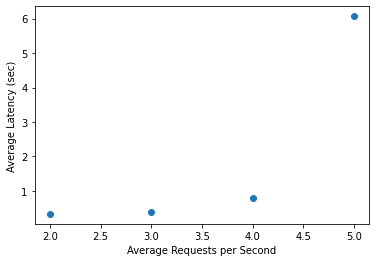

In [34]:
# Partial plot. Don't include this plot in the blog.
plt.scatter(agg_results.index, agg_results["latency", "mean"])
plt.xlabel("Average Requests per Second")
plt.ylabel("Average Latency (sec)")

In [35]:
# Don't include this cell in the blog.
# Make sure that TorchServe is shut down before we continue.
torchserve_is_running = True
try:
    requests.get('http://127.0.0.1:8081/models').json()
except requests.exceptions.ConnectionError:
    torchserve_is_running = False
if torchserve_is_running:
    raise ValueError('Please shut down TorchServe before continuing.')

### Benchmark run with zero-copy model loading

In [41]:
# Make sure the Ray models are up
try:
    requests.put(
        'http://127.0.0.1:8000/predictions/intent_en', 
        json.dumps(INTENT_INPUT)).json()
except requests.exceptions.ConnectionError as e:
    raise ValueError('Please start up the zero-copy model deployment before continuing.') from None

In [42]:
# Same benchmark, but pointed at our zero-copy implementation.
def call_ray(model_type: str, language: str):
    return call_model(model_type, language, 8000)

results_zerocopy = run_benchmarks(call_ray)

Running at 2 requests/sec.
Running at 3 requests/sec.
Running at 4 requests/sec.
Running at 5 requests/sec.
Running at 6 requests/sec.
Running at 7 requests/sec.
Running at 8 requests/sec.
Running at 9 requests/sec.
Running at 10 requests/sec.
Running at 11 requests/sec.
Stopping due to number of failures (9) exceeding allowable limit (0)


In [43]:
timeout_rate = results_zerocopy['request_rate'].max()
agg_results_zerocopy = (
    results_zerocopy[results_zerocopy['request_rate'] < timeout_rate]
    .groupby("request_rate")
    .aggregate({"latency": ["mean", "median", "max"]}))
agg_results_zerocopy

latency                     
                  mean    median        max
request_rate                               
2             0.344801  0.294816   2.941666
3             0.458517  0.306698   3.183783
4             1.231333  0.545989   5.528882
5             1.532119  1.095748   6.054023
6             1.634467  1.026585   8.508689
7             1.754565  1.159115   7.509175
8             1.680933  1.281266   6.736536
9             2.165534  1.753185  17.289803
10            2.278934  1.792043  10.409607

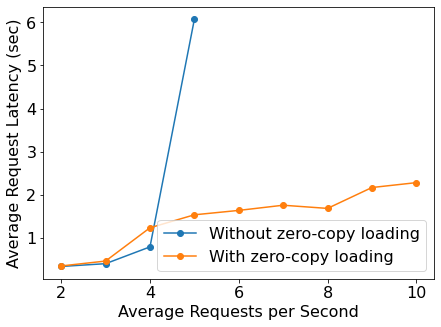

In [44]:
# Plot the two sets of results against each other.
plt.rcParams.update({"font.size": 16})
plt.figure(figsize=(7, 5))
plt.plot(agg_results.index, agg_results["latency", "mean"],
         "-o", label="Without zero-copy loading")
plt.plot(agg_results_zerocopy.index, 
         agg_results_zerocopy["latency", "mean"],
         "-o", label="With zero-copy loading")
plt.xlabel("Average Requests per Second")
plt.ylabel("Average Request Latency (sec)")
plt.legend()